In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd
from multiprocessing import Pool
from itertools import product



In [2]:
home_path = '/home/sgillen/work/'

checkpoint_path = home_path + \
"seagul/seagul/notebooks/lorenz/data/tune/custom_reward/PPO/PPO_linear_z-v0_21a281cc_2020-02-12_21-31-48o6kp5nwx/checkpoint_455/checkpoint-455"

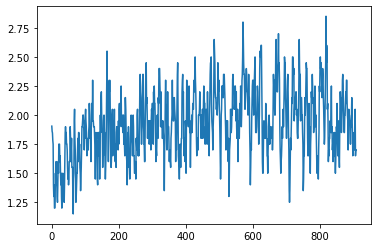

In [3]:
# Some delightfully ugly python to infer where everything else is...
config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
config = dill.load(open(config_path, 'rb'))
env_name = config['env']

csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
df = pd.read_csv(csv_path)
plt.plot(df['episode_reward_mean'])

In [4]:
def do_rollout(init_point):
    env = gym.make(env_name, **config['env_config'])
    obs = env.reset(init_point)

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []

    done = False

    while not done:
        actions, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
        obs, reward, done, _ = env.step(np.asarray(actions))

        action_hist.append(np.copy(actions))
        obs_hist.append(np.copy(obs))
        reward_hist.append(np.copy(reward))


    action_hist = np.stack(action_hist)
    obs_hist = np.stack(obs_hist)
    reward_hist = np.stack(reward_hist)
    
    return obs_hist, action_hist, reward_hist


ray.shutdown()
ray.init()

trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = td3.TD3Trainer(config)
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)

trainer.restore(checkpoint_path)

2020-02-20 18:58:57,256	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-20 18:58:57,257	INFO resource_spec.py:212 -- Starting Ray with 12.06 GiB memory available for workers and up to 6.04 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-20 18:58:57,572	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
2020-02-20 18:58:57,772	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-20 18:58:57,789	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-02-20 18:59:02,018	WARNING trainable.py:210 -- Getting current IP.
2020-02-20 18:59:02,019	INFO trainable.py:416 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/seagul/seagul/notebooks/lorenz/data/tune/euler/PPO/PPO_linear_z-v

# Rollouts

0.0


Text(0.5, 1.0, 'Actions')

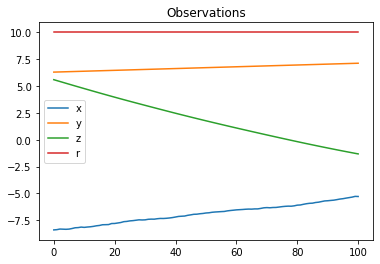

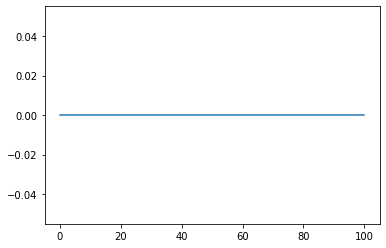

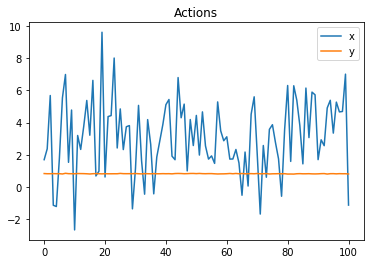

(pid=28921) 2020-02-20 18:59:02.806820: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
obs_hist, action_hist, reward_hist = do_rollout(init_point = np.random.uniform(-10,10,3))
print(sum(reward_hist))

plt.plot(obs_hist)
plt.title('Observations')
plt.legend(['x', 'y', 'z', 'r'])

plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(action_hist)
plt.legend(['x', 'y'])
plt.title('Actions')

Text(0.5, 0.92, 'phase diagram')

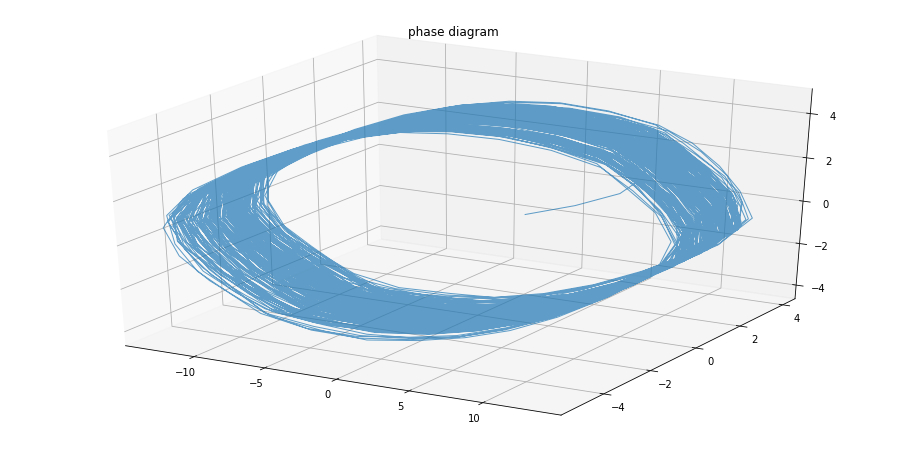

In [11]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')

# Local Point Analysis

In [10]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4900:,:]
config['env_config']['num_steps'] = num_steps

(pid=26610) 2020-02-20 10:45:08.129581: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [96]:
seed_point = np.array(obs_hist[-1,:3])
dx = dy = dz = 1e-6

deltas = itertools.product([-dx, dx, 0], [-dy, dy, 0], [-dz, dz, 0])
deltas = np.array(list(deltas))

init_points = seed_point + deltas

final_points = np.zeros_like(init_points)
min_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config['env_config']['num_steps']+1, init_points.shape[1]))

trainer.get_policy().cur_noise_scale = 0.0

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]

In [97]:
num_trajs = trajs.shape[0]

min_x = np.zeros((num_trajs, num_steps))
min_y = np.zeros((num_trajs, num_steps))
min_z = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_dxz = np.zeros((num_trajs, num_steps))

for i in range(trajs.shape[0]):
    for t in range(num_steps):
        min_x[i,t] = np.min(np.linalg.norm((trajs[i,t,0] - limit_set[:,0]).reshape(1,-1),axis=0))
        min_y[i,t] = np.min(np.linalg.norm((trajs[i,t,1] - limit_set[:,1]).reshape(1,-1),axis=0))
        min_z[i,t] = np.min(np.linalg.norm((trajs[i,t,2] - limit_set[:,2]).reshape(1,-1),axis=0))
        min_d[i,t] = np.min(np.linalg.norm(trajs[i,t,:] - limit_set[:,:3], axis=1))
        min_dxz[i,t] = np.min(np.linalg.norm(trajs[i,t,0::2] - limit_set[:,0::2], axis=1))

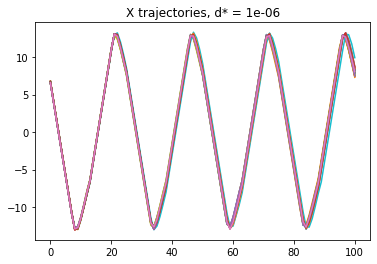

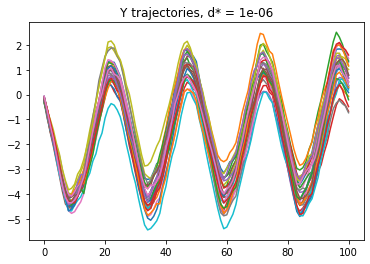

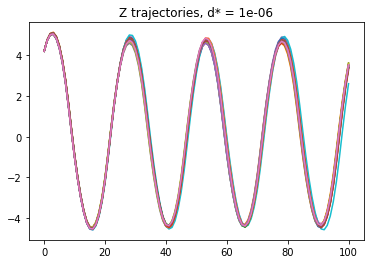

In [98]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,0])
    plt.title("X trajectories, d* = " + str(dx))
    
plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,1])
    plt.title("Y trajectories, d* = " + str(dy))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,2])
    plt.title("Z trajectories, d* = " + str(dz))

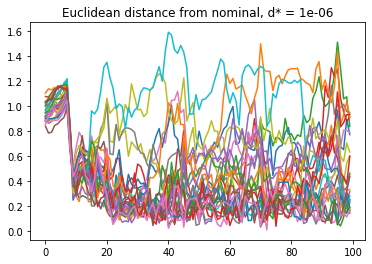

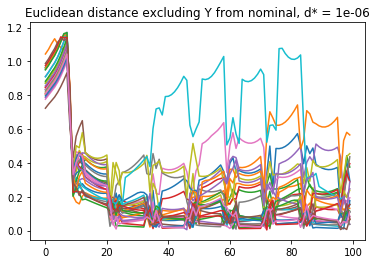

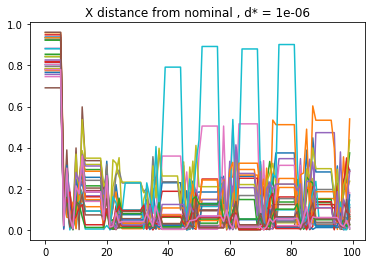

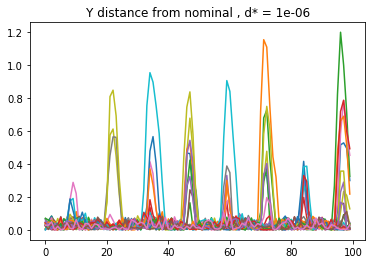

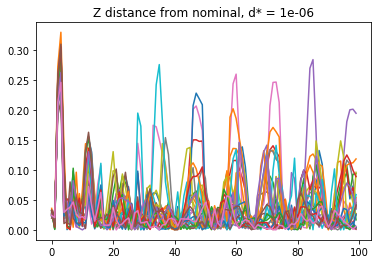

In [99]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_d[i,:])
    plt.title("Euclidean distance from nominal, d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_dxz[i,:])
    plt.title("Euclidean distance excluding Y from nominal, d* = " + str(dx))
    
plt.figure()    
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_x[i,:])
    plt.title("X distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_y[i,:])
    plt.title("Y distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_z[i,:])
    plt.title("Z distance from nominal, d* = " + str(dx))

# Global point analysis

In [100]:
num_points = int(1e3)
config["env_config"]["num_steps"] = 1000

init_points = np.random.uniform(low = np.array([-10,-10,-10]), high = np.array([10, 10, 10]), size=(num_points,3))
final_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config["env_config"]["num_steps"]+1, init_points.shape[1]))

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]
    final_points[i,:] = obs_hist[-1,:3]

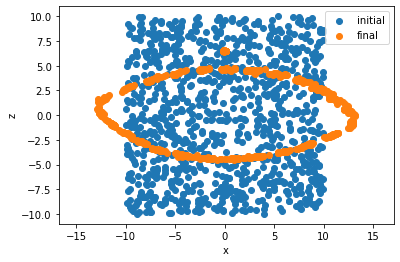

In [101]:
plt.scatter(init_points[:,0], init_points[:,2])
plt.scatter(final_points[:,0], final_points[:,2])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.legend(['initial', 'final'])

# Network output analysis

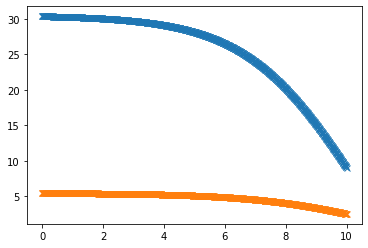

In [102]:
num_points = 1000

obs = np.array([0.0,0.0,0.0,10.0])

ys  = np.linspace(-10,10,num_points)
xs  = np.linspace(0,10,num_points)

action_arr = np.zeros((num_points, 2))
var = np.zeros((num_points,2))
logp = np.zeros((num_points,1))
vf_preds = np.zeros((num_points,1))

for i,xy in enumerate(zip(xs,ys)):
    x = xy[0]; y = xy[1]
    
    obs[0] = x; #obs[1] = y
    
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    actions = out_dict['behaviour_logits'][0:2]
    var[i] = out_dict['behaviour_logits'][2:]
    logp[i] = out_dict['action_logp']
    vf_preds[i] = out_dict['vf_preds']


    action_arr[i] = actions
    
    
plt.plot(xs, action_arr[:,0], 'x')
plt.plot(xs, action_arr[:,1], 'x')

# Meshing dimensionality analysis

In [8]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4900:,:]
config['env_config']['num_steps'] = num_steps

In [16]:
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')

d_min = 1e-8; d_max = 25
d_vals = np.linspace(d_min, d_max, 1000)
mesh_sizes = []
        
for d in d_vals:
    orig = []
    mesh = []

    for point in limit_set[:,:3]:
        orig.append(point)

    while True:
        sample = random.sample(orig,1)[0]
        removearray(orig, sample)
        mesh.append(sample)

        for item in orig:
            if(np.linalg.norm(sample - item) < d):
                removearray(orig, item)

        if len(orig) == 0:
            break
            
    mesh_sizes.append(len(mesh))

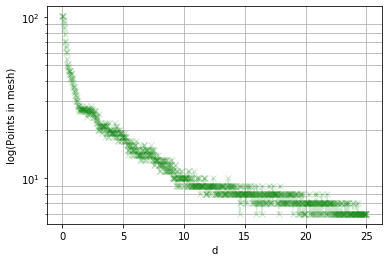

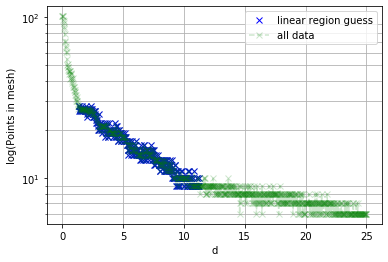

In [39]:
import scipy.optimize as opt

lin_begin = 55; lin_end = 450
xdata = np.array(d_vals[lin_begin:lin_end])
ydata = np.array(mesh_sizes[lin_begin:lin_end])

#plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, mesh_sizes, 'gx--', alpha=.2)
#plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.gca().xaxis.grid(True)  # minor grid on too
plt.gca().yaxis.grid(True, which='minor')  # minor grid on too

plt.figure()

plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, mesh_sizes, 'gx--', alpha=.2)
plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.gca().xaxis.grid(True)  # minor grid on too
plt.gca().yaxis.grid(True, which='minor')  # minor grid on too

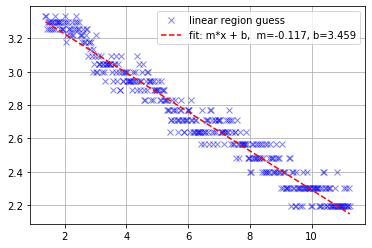

2020-02-20 13:43:08,246	ERROR worker.py:1065 -- listen_error_messages_raylet: Connection closed by server.
2020-02-20 13:43:08,247	ERROR import_thread.py:93 -- ImportThread: Connection closed by server.
2020-02-20 13:43:08,252	ERROR worker.py:965 -- print_logs: Connection closed by server.


(pid=raylet) *** Aborted at 1582234988 (unix time) try "date -d @1582234988" if you are using GNU date ***
(pid=raylet) PC: @                0x0 (unknown)
(pid=raylet) *** SIGTERM (@0x3e8000029b6) received by PID 26564 (TID 0x7f809d654780) from PID 10678; stack trace: ***
(pid=raylet)     @     0x7f809cb27890 (unknown)
(pid=raylet)     @     0x7f809c425b77 epoll_wait
(pid=raylet)     @           0x4187ec boost::asio::detail::epoll_reactor::run()
(pid=raylet)     @           0x418f29 boost::asio::detail::scheduler::run()
(pid=raylet)     @           0x409e31 main
(pid=raylet)     @     0x7f809c325b97 __libc_start_main
(pid=raylet)     @           0x40e8c1 (unknown)


In [52]:
def f(x,m,b):
    return m*x + b

popt, pcov = opt.curve_fit(f, xdata, np.log(ydata))

plt.plot(xdata, np.log(ydata), 'bx', alpha=.5)
plt.plot(xdata, f(xdata, *popt),'r--')
plt.legend(['linear region guess', 'fit: m*x + b,  m=%5.3f, b=%5.3f' % tuple(popt)])
plt.gca().xaxis.grid(True)  # minor grid on too
plt.gca().yaxis.grid(True)  # minor grid on too

In [24]:
env = gym.make(env_name, **config['env_config'])

x_min = -10; x_max = 10; num_x = 1
x_vals = np.linspace(x_min, x_max, num_x)

y_min = -10; y_max = 10; num_y = 1
y_vals = np.linspace(y_min, y_max, num_y)

z_min = -10; z_max = 10; num_z = 1
z_vals = np.linspace(z_min, z_max, num_z)

means = np.zeros((x_vals.size, y_vals.size, z_vals.size, env.action_space.shape[0]))
stds = np.zeros((x_vals.size, y_vals.size, z_vals.size, env.action_space.shape[0]))

import time
start = time.time()

def do_eval(xyz):
    obs = np.array(xyz + (10,))
    print("e")
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    print("z")


    actions = out_dict['behaviour_logits'][0:2]
    std = out_dict['behaviour_logits'][2:]
    print("ello")
    return actions, std

pool = Pool(processes=1) #defaults to number of available CPU's
for ind, res in enumerate(pool.imap(do_eval, product(x_vals, y_vals, z_vals))):
        means.flat[ind] = res[0] 
        std.flat[ind] = res[1]

end = time.time()
print(end - start)

e


KeyboardInterrupt: 

In [11]:
env = gym.make(env_name, **config['env_config'])

x_min = -10; x_max = 10; num_x = 1
x_vals = np.linspace(x_min, x_max, num_x)

y_min = -10; y_max = 10; num_y = 1
y_vals = np.linspace(y_min, y_max, num_y)

z_min = -10; z_max = 10; num_z = 1
z_vals = np.linspace(z_min, z_max, num_z)

means = np.zeros((x_vals.size, y_vals.size, z_vals.size, env.action_space.shape[0]))
stds = np.zeros((x_vals.size, y_vals.size, z_vals.size, env.action_space.shape[0]))

import time
start = time.time()

def do_eval(xyz):
    obs = np.array(xyz + (10,))
    print("e")
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    print("z")


    actions = out_dict['behaviour_logits'][0:2]
    std = out_dict['behaviour_logits'][2:]
    print("ello")
    return actions, std

pool = Pool(processes=1) #defaults to number of available CPU's
for ind, res in enumerate(pool.imap(do_eval, product(x_vals, y_vals, z_vals))):
        means.flat[ind] = res[0] 
        std.flat[ind] = res[1]

end = time.time()
print(end - start)

NameError: name 'obs' is not defined

In [8]:
env = gym.make(env_name, **config['env_config'])

x_min = -10; x_max = 10; num_x = 5
x_vals = np.linspace(x_min, x_max, num_x)

y_min = -10; y_max = 10; num_y = 5
y_vals = np.linspace(y_min, y_max, num_y)

z_min = -10; z_max = 10; num_z = 5
z_vals = np.linspace(z_min, z_max, num_z)

x_means = np.zeros((x_vals.size, y_vals.size, z_vals.size))
y_means = np.zeros((x_vals.size, y_vals.size, z_vals.size))
                  
x_std = np.zeros((x_vals.size, y_vals.size, z_vals.size))
y_std = np.zeros((x_vals.size, y_vals.size, z_vals.size))


pool = Pool()
import time
start = time.time()


def do_eval(xyz):
    obs = np.array(xyz + (10,))
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    actions = out_dict['behaviour_logits'][0:2]
    std = out_dict['behaviour_logits'][2:]
    return actions, std

for ind, res  in enumerate(product(x_vals, y_vals, z_vals)):
        res = do_eval(xyz)
        x_means.flat[ind] = res[0][0]
        y_means.flat[ind] = res[0][1]
                 
        x_std.flat[ind] = res[1][0]
        y_std.flat[ind] = res[1][1]

end = time.time()
print(end - start)

0.13884353637695312


In [59]:
from scipy.io import savemat
savemat("policy_map.mat", {"x_means":x_means, "z_means":z_means, "x_std":x_std, "z_std":z_std, "x_eval":x_vals, "y_eval":y_vals, "z_eval":z_vals})

In [43]:
60/0.0016977787017822266


35340.29490240135

In [52]:
 50*50*50/35340.29490240135

3.537038962046305

In [7]:
trainer